In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Wald Sequential Probability Ratio Test

In this exercise, we will apply Wald's sequential probability ratio test to manufacturing process data. 

Let's assume we are operating a "widget" factory where we produce some batch of widgets in a given week, and we need to determine if a given batch has an acceptable defect rate. 

The simplest solution would be to to test all widgets in each batch, but as we'll see, this actually is a lot more data than we really need to collect. In reality, it also might be prohibitively time consuming or expensive to actually review all widgets in the batch, so it is helpful to develop time and cost saving measures. 

As the next simplest solution, we could just arbitrarily sample some subset of widgets, but without being careful, we might more or less widgets than really necessary. 

Wald's sequential probability ratio test gives us a principled, statistically-backed sequential sampling method to measure the batch's defect rate, where our confidence in the batch's defect rate is a function of the number of samples and the observed defect rate. 

To start off, let's create a synthetic dataset of widgets. We'll represent a widget batch first as a list where each list element represents a widget with a binary label indicating if it is defective. In the cell below, create a function that returns a list with length n, where n is the number of widgets, and each value in the list is 1 if defective, and 0 if not defective. 

In [6]:
def make_widget_dataset(p_defective, n_widgets):
    
    ### BEGIN SOLUTION
    widgets = list(np.random.random(size=n_widgets))
    widgets = [1 if i < p_defective else 0 for i in widgets]
    ### END SOLUTION
    
    return widgets

In [7]:
# Here's a helper function we'll use to convert your widget list to a pandas dataframe

def convert_widget_list_to_batch_df(widget_list):
    batch_df = pd.DataFrame(widget_list, columns=['defective'])
    batch_df.index = batch_df.index + 1
    batch_df = batch_df.reset_index()
    batch_df.columns = ['m', 'defective']
    return batch_df

In [8]:
# Here's a test to make sure you've generated your data correctly. 

widgets = make_widget_dataset(0.01, 100000)
batch_df = convert_widget_list_to_batch_df(widgets)
assert round((batch_df['defective'].sum() / len(batch_df)), 2) == 0.01, "Your function does not appear to produce a batch of widgets with the correct defect probability"

### BEGIN HIDDEN TESTS

widgets2 = make_widget_dataset(0.02, 100000)
batch_df2 = convert_widget_list_to_batch_df(widgets2)
assert round((batch_df2['defective'].sum() / len(batch_df2)), 2) == 0.02, "Your function does not appear to produce a batch of widgets with the correct defect probability"


### END HIDDEN TESTS

Below see a screenshot from Wald's paper outlining the instructions for the probability ratio test. We're going to implement functions to compute these upper and lower bounds, and use them to test different manufacturing batches. 

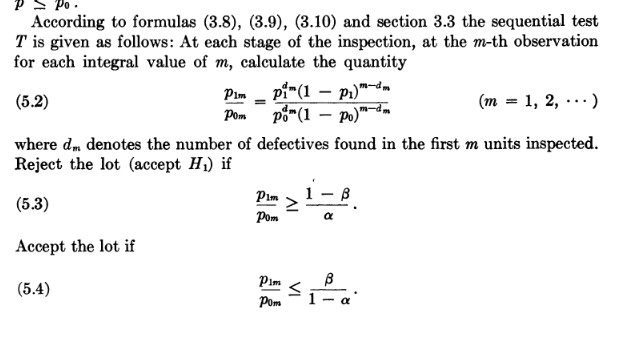

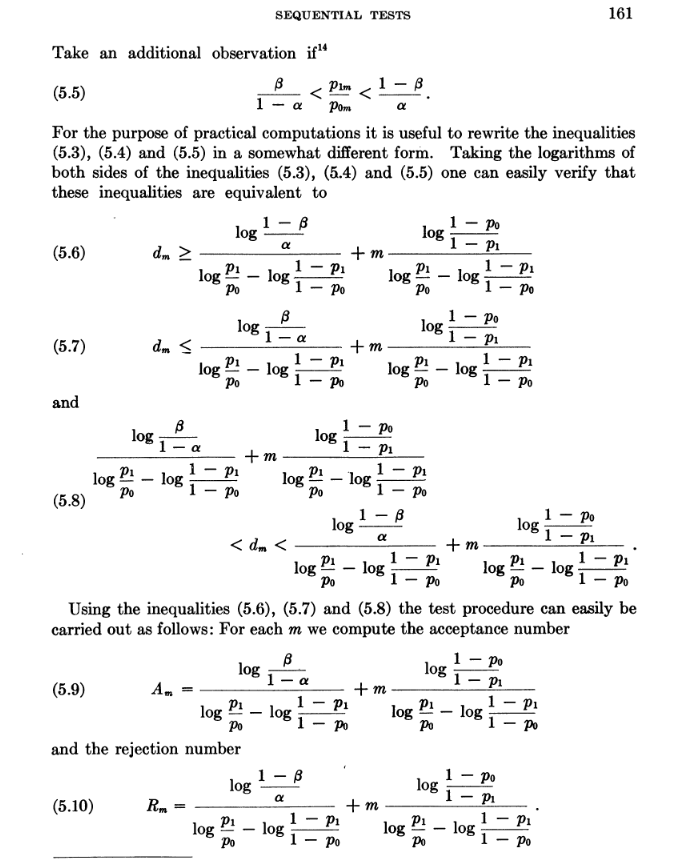

In case it isn't clear what this algorithm is doing, for each widget in the sample we compute the acceptance number and rejection number based on some pre-determined signficance level $\alpha$ and statistical power $1 - \beta$. $p_0$ represents our ideal upper bound on the defect rate, and $p_1$ represents the maximum defect rate we are willing to accept. These values should be determined prior to running our test. 

With these test parameters specified, we start sampling widgets, and for each widget sampled, compare the acceptance and rejection numbers to our actual defect rate.  If the defect rate is above the acceptance number but below the rejection number, we keep sampling. We continue sampling until we consistently see results above the rejection number or below the acceptance number. 

We'll now write some functions to help us determine these values for our manufacturing process. Let's start by writing a function to compute our acceptance number $A_m$ via equation 5.9. This gives us a value at each sampled widget $m$. Recall that since we have $n$ total widgets, $ 1 \leq m \leq n$. 

In [10]:
# Equation 5.9

def calculate_acceptance_number(alpha, beta, p0, p1, m):
    
    ### BEGIN SOLUTION
    A_m  =((np.log(beta / (1 - alpha)) / 
           (np.log(p1 / p0) - np.log((1 - p1) / (1 - p0)))) + 
          (m * (np.log((1 - p0) / (1 - p1)) / 
                (np.log(p1 / p0) - np.log((1 - p1) / (1 - p0))))))
    
    ### END SOLUTION
    
    return A_m

We'll do the same thing now for our rejection number, $R_m$, using equation 5.10. 

In [11]:
# Equation 5.10

def calculate_rejection_number(alpha, beta, p0, p1, m):
     
    ### BEGIN SOLUTION    
    R_m = ((np.log((1 - beta) / alpha)) / 
          (np.log(p1 / p0) - np.log((1 - p1) / (1 - p0))) + 
          (m * (np.log((1 - p0) / (1 - p1)) / 
                (np.log(p1 / p0) - np.log((1 - p1) / (1 - p0))))))
    
    ### END SOLUTION
    
    return R_m

Before we run our functions on our synthetic data, let's test that they're producing the results we expect. We'll run the test assuming standard values of $\alpha = 0.05$, $\beta = 0.2$, corresponding to 5% significance and 80% statistical power respectively. Then we'll assume our ideal defect rate is 10% ($p_0 = 0.1$), and our maximum acceptable defect rate is 30% ($p_1 = 0.3$). Finally, let's assume we're on the 3rd widget ($m = 3$)

In [13]:
round(calculate_rejection_number(0.05, 0.2, 0.2, 0.4, 10), 1)

5.8

In [54]:
# Here's a test to verify that you're calculating the acceptance and rejection numbers correctly. 

assert round(calculate_acceptance_number(0.05, 0.2, 0.1, 0.3, 3), 1) == -0.6, 'Acceptance number not computed correctly'
assert round(calculate_rejection_number(0.05, 0.2, 0.1, 0.3, 3), 1) == 2.6, 'Rejection number not computed correctly'

### BEGIN HIDDEN TESTS

assert round(calculate_acceptance_number(0.05, 0.2, 0.2, 0.4, 10), 1) == 1.3, 'Acceptance number not computed correctly'
assert round(calculate_rejection_number(0.05, 0.2, 0.2, 0.4, 10), 1) == 5.8, 'Rejection number not computed correctly'

### END HIDDEN TESTS

Remember we only have 3 widgets so it's easy to think this through. It would be impossible for us to have negative defective widgets, so no matter what our defect rate will be above the acceptance number at -0.6. We would only be above our rejection number of 2.6 if all 3 widgets were defective. So, unless all 3 widgets are defective, our true defect rate will be above the acceptance number and below the rejection number, so the test will tell us to continue sampling.  If all 3 widgets are defective, that would tell us that we have to reject the batch. 

In practice, we should typically only make conclusions about the batch when we see sustained values outside of the bounds - it's possible that the sample could exit the bounds and later re-enter them. 

Let's start by evaluating an example batch with a very low defect rate. Using the functions above, let's generate a batch of 100 widgets with a defect probability of 0.001.

In [17]:
widgets = make_widget_dataset(0.001, 100)
low_defect_batch_df = convert_widget_list_to_batch_df(widgets)

For each index value (i.e. sampled widget), let's compute the bounds. Note that we're computing over the entire dataset because that's easy for us computationally and we want to illustrate that you don't need to sample the entire dataset. Were this a real test, you could do the same thing sequentially and stop earlier. 

In [18]:
# d_m is number of defectives found in the first m units inspected 
low_defect_batch_df['d_m'] = low_defect_batch_df['defective'].cumsum()

Let's again assume $\alpha = 0.05$ (5% significance), $\beta = 0.2$ ( 80% statistical power), $p_0 = 0.1$ (ideal defect rate is 10%), and $p_1 = 0.3$ (our maximum acceptable defect rate is 30%).

In [19]:
alpha = 0.05
beta = 0.2
p0 = 0.1
p1 = 0.3

low_defect_batch_df['A_m'] = low_defect_batch_df['m'].apply(lambda x: calculate_acceptance_number(alpha, beta, p0, p1, x))
low_defect_batch_df['R_m'] = low_defect_batch_df['m'].apply(lambda x: calculate_rejection_number(alpha, beta, p0, p1, x))

We can plot the results to see what these bounds look like compared to our defect rate. 

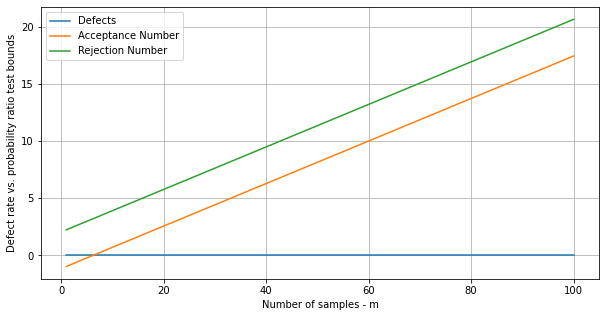

In [20]:
plt.figure(figsize=(10,5))
sns.lineplot(low_defect_batch_df['m'], low_defect_batch_df['d_m'], label='Defects')
sns.lineplot(low_defect_batch_df['m'], low_defect_batch_df['A_m'], label='Acceptance Number', linestyle='--')
sns.lineplot(low_defect_batch_df['m'], low_defect_batch_df['R_m'], label='Rejection Number', linestyle='--')
plt.grid()
plt.xlabel('Number of samples - m')
plt.ylabel('Defect rate vs. probability ratio test bounds')
plt.legend()
plt.show()

Let's write a function to check for a given batch dataframe if we should accept or reject the batch based on its defect rate. We also want to determine the value for $m$ when we can make that determination. Let's assume if we see 10 observations in a row outside the bounds, that is enough to make the decision, and we cut off the sampling at the value for $m$ 10 samples after leaving the bounds. 

In [14]:
# Write a function to accept or reject the batch, and determine the stopping index. 
# stop_index should be the integer value of m occuring 10 samples after where the defect rate leaves the bounds
# defective should be False if batch passes quality inspection and True if batch fails quality inspection


def accept_or_reject_batch(batch_df):
    
    ### BEGIN SOLUTION
    batch_df['in_bounds'] = batch_df.apply(lambda x: True if ((x['d_m'] > x['A_m']) and 
                                                          (x['d_m'] < x['R_m'])) else False, axis=1)
    
    for i in batch_df.index:
        if batch_df.loc[i]['in_bounds'] == False:
            if batch_df.loc[i: i + 10]['in_bounds'].sum() == 0:
                stop_index = i + 11
                keep_sampling = False
                break
            
    defect_rate = batch_df.loc[stop_index-1]['d_m']
    acceptance_number = batch_df.loc[stop_index-1]['A_m']
    rejection_number = batch_df.loc[stop_index-1]['R_m']

    if defect_rate < acceptance_number:
        defective = False
    elif defect_rate > rejection_number:
        defective = True
    ### END SOLUTION
    
    
    return stop_index, defective

In [24]:
# Here's a test to determine that you're analyzing the low defect batch correctly. 

stop_index, defective = accept_or_reject_batch(low_defect_batch_df)
assert stop_index < 20, 'We should have a stop index occuring before 20 samples'
assert defective == False, 'This batch should not be labeled defective'


### BEGIN HIDDEN TESTS

defective_widgets = make_widget_dataset(0.99, 100)
very_high_defect_batch_df = convert_widget_list_to_batch_df(defective_widgets)
very_high_defect_batch_df['d_m'] = very_high_defect_batch_df['defective'].cumsum()
very_high_defect_batch_df['A_m'] = very_high_defect_batch_df['m'].apply(lambda x: calculate_acceptance_number(alpha, beta, p0, p1, x))
very_high_defect_batch_df['R_m'] = very_high_defect_batch_df['m'].apply(lambda x: calculate_rejection_number(alpha, beta, p0, p1, x))
stop_index, defective = accept_or_reject_batch(very_high_defect_batch_df)
assert stop_index < 20
assert defective == True

### END HIDDEN TESTS

We'll now run this test on a batch with a much higher defect rate (assume $p = 0.35$), and confirm our functions produce the expected results. 

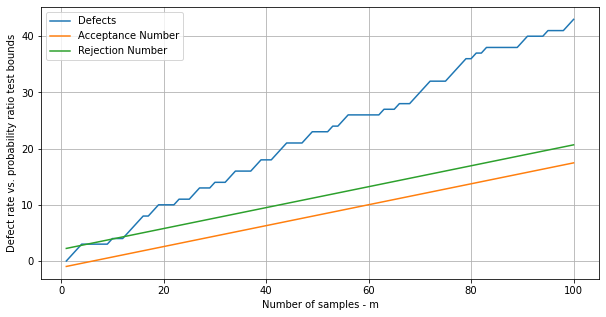

In [149]:
# Make dataset
widgets = make_widget_dataset(0.35, 100)
high_defect_batch_df = convert_widget_list_to_batch_df(widgets)

# Compute defect rate and acceptance/rejection numbers
high_defect_batch_df['d_m'] = high_defect_batch_df['defective'].cumsum()
high_defect_batch_df['A_m'] = high_defect_batch_df['m'].apply(lambda x: calculate_acceptance_number(alpha, beta, p0, p1, x))
high_defect_batch_df['R_m'] = high_defect_batch_df['m'].apply(lambda x: calculate_rejection_number(alpha, beta, p0, p1, x))

# Plot results
plt.figure(figsize=(10,5))
sns.lineplot(high_defect_batch_df['m'], high_defect_batch_df['d_m'], label='Defects')
sns.lineplot(high_defect_batch_df['m'], high_defect_batch_df['A_m'], label='Acceptance Number', linestyle='--')
sns.lineplot(high_defect_batch_df['m'], high_defect_batch_df['R_m'], label='Rejection Number', linestyle='--')
plt.grid()
plt.xlabel('Number of samples - m')
plt.ylabel('Defect rate vs. probability ratio test bounds')
plt.legend()
plt.show()

In [ ]:
# Here's a test to determine that you're analyzing the high defect batch correctly. 

stop_index, defective = accept_or_reject_batch(high_defect_batch_df)
assert stop_index < 50, 'We should have a stop index occuring before 50 samples'
assert defective == True, 'This batch should be labeled defective'

Now it's your turn to play around with this. Try varying different parameters of the widget batches to see how changing the defect rate changes the results of the tests, and try varying the parameters of the tests to see how changing the probability thresholds impact the results of the tests. Can you think of another dataset you could try applying this to? 

In [ ]:
# Try varying parameters and see what happens!